# Truncating the GW Waveform during the Inspiral Phase

First, we install the necessary packages.

In [57]:
#Here the necessary packages are installed
import datetime
import pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
import numpy as np
import statistics as st
from scipy.stats import norm
from scipy import optimize
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit
import lalsimulation
import cmath
import math
from shapely.geometry import LineString
from scipy.integrate import quad, simps, cumtrapz, romb
from numpy import diff, gradient
from pycbc import pnutils
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.waveform.utils import amplitude_from_frequencyseries, phase_from_frequencyseries, frequency_from_polarizations
from pycbc.waveform.waveform import get_fd_waveform_from_td
st = datetime.datetime.now()

We then define the fundamental constants and physical parameters

In [52]:
 #Here the fundamental constants are defined
G = 6.6743015e-11
c = 299792458
  
#Here we set the luminosity distance
r = 410.0 #Luminosity distance in megaparsecs
L = r*3.086*10**22 #luminosity distance in SI units
j=1
M_R=1

m1 = 60*M_R*j/(1+j)
m2 = 60*M_R/(1+j) 
M_sun = 1.989e+30 
mass_1 = m1*M_sun
mass_2 = m2*M_sun
M_chirp = (((mass_1*mass_2)**3)/(mass_1+mass_2))**(1/5) 

Afterwards, we define functions that output the time arrays, frequency arrays, and the waveforms.

In [53]:
def t(**kwargs):
    hp, hc = get_td_waveform(approximant="IMRPhenomPv2",
                                 delta_t=1.0/4096,
                                 inclination=0,
                                 coa_phase=0,
                                 distance=r,
                                 **kwargs)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    return hp.sample_times
def freq(**kwargs):
    hp_3, hc_3 = get_td_waveform(approximant="IMRPhenomPv2",
                                 delta_t=1.0/4096,
                                 inclination=0,
                                 coa_phase=0,
                                 distance=r,
                                 **kwargs)
    hp_3, hc_3 = hp_3.trim_zeros(), hc_3.trim_zeros()
    GW_freq = frequency_from_polarizations(hp_3, hc_3)
    return GW_freq
def h_1(**kwargs):
    hp_1, hc_1 = get_td_waveform(approximant="IMRPhenomPv2",
                                 delta_t=1.0/4096,
                                 inclination=0,
                                 coa_phase=0,
                                 distance=r,
                                 **kwargs)
    hp_1, hc_1 = hp_1.trim_zeros(), hc_1.trim_zeros()
    return hp_1-1j*hc_1
  
  #Let the hp_2 and hc_2 be the plus and cross polarization at $\theta=\pi$ and $\phi=0$ 
def h_2(**kwargs):
    hp_2, hc_2 = get_td_waveform(approximant="IMRPhenomPv2",
                                 delta_t=1.0/4096,
                                 inclination=np.pi,
                                 coa_phase=0,
                                 distance=r,
                                 **kwargs)
    hp_2, hc_2 = hp_2.trim_zeros(), hc_2.trim_zeros()
    return hp_2-1j*hc_2

Next, we use the inspiral frequency bound $0.004\leq Mf\leq 0.018$ to trucate the waveform.

In [55]:
Mf_high = 0.018
f_high = (Mf_high/(m1+m2))/4.9268590524283380365364622010990643101143620971335214614584e-6
Mf_low=0.004
f_low = (Mf_low/(m1+m2))/4.9268590524283380365364622010990643101143620971335214614584e-6


t_0=t(dchi0=-0.5, dchi1=-0.5, dchi4=0, mass1=m1, mass2=m2, spin1z=0, spin2z=0, f_lower=0.75*f_low)
t_m_0_index =  np.argmin(np.absolute(t_0))

h1=h_1(dchi0=-0.5, dchi1=-0.5, dchi4=0, mass1=m1, mass2=m2, spin1z=0, spin2z=0, f_lower=0.75*f_low)
f = freq(dchi0=-0.5, dchi1=-0.5, dchi4=0, mass1=m1, mass2=m2, spin1z=0, spin2z=0, f_lower=0.75*f_low)


t_high_index = np.argmin(np.absolute(f[5000:t_m_0_index]-f_high))
t_low_index = np.argmin(np.absolute(f[round(0.5*len(f)):t_m_0_index]-f_low))
t_high = t_0[5000+t_high_index]

t_lower = t_0[round(0.5*len(t_0))+t_low_index]

GM_over_c3 = G*M_chirp/c**3

v_over_c = (G*(mass_1+mass_2)*np.pi*f/c**3)**(1/3)
R = ((G*(mass_1+mass_2))/((np.pi*f)**2))**(1/3)
R_s = 2*G*(mass_1+mass_2)/(c**2)
R_over_R_s = R/R_s

Finally, we plot the frequency evolution, the time-domain waveform, the relative velocity, and the orbital separation.

[-0.5  -0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05
  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5 ]


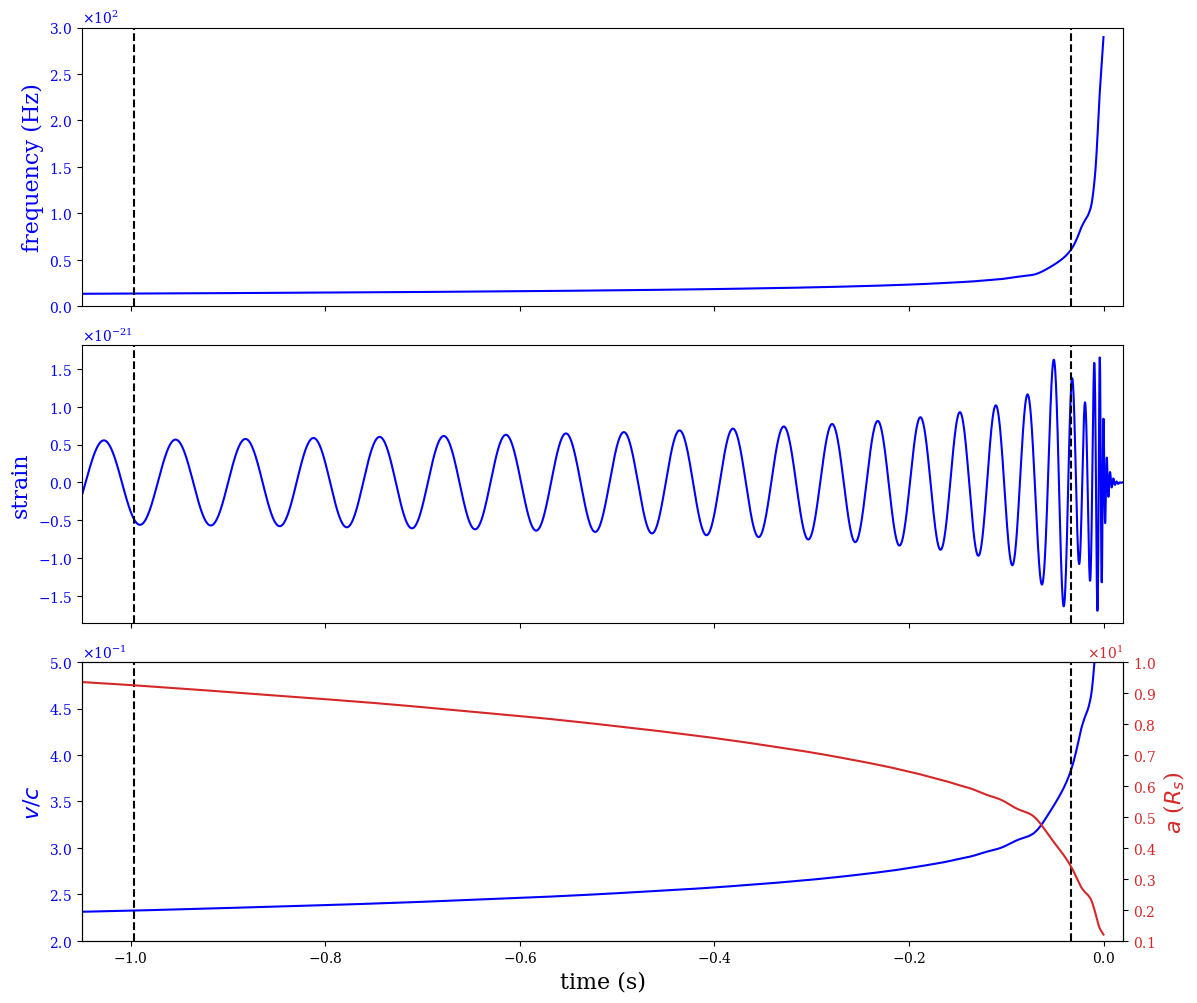

In [56]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["figure.figsize"] = (12, 10)

fig, axs = plt.subplots(3, 1, sharex=True)

#first plot
color = 'blue'
axs[0].plot(t_0[0:t_m_0_index],f[0:t_m_0_index], color=color)
axs[0].set_ylabel('frequency (Hz)', color=color, fontsize=16)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].axvline(t_high,  color='black', linestyle='dashed')
axs[0].axvline(t_lower,  color='black', linestyle='dashed')
axs[0].axvline(t_0[int(0.5*len(t_0))],  color='black', linestyle='dashed')
axs[0].set_ylim(0,300)
#second plot
color = 'blue'
axs[1].plot(t_0,h1, color=color)
axs[1].set_ylabel('strain', color=color, fontsize=16)
axs[1].tick_params(axis='y', labelcolor=color)
axs[1].axvline(t_high,  color='black', linestyle='dashed')
axs[1].axvline(t_lower,  color='black', linestyle='dashed')
#axs[1].set_ylim(-2e-21,2e-21)
#third plot
color = 'blue'
axs[2].set_ylabel('$v/c$', color=color, fontsize=16)  
axs[2].plot(t_0[0:t_m_0_index],v_over_c[0:t_m_0_index], color=color)
axs[2].tick_params(axis='y', labelcolor=color)
axs[2].set_xlabel('time (s)', fontsize=16)
axs[2].axvline(t_high,color='black', linestyle='dashed')
axs[2].axvline(t_lower,  color='black', linestyle='dashed')
axs[2].set_ylim(0.2,0.5)

dchi_2 = np.linspace(-0.5,0.5, 21) 
print(dchi_2)
#delta_chi_4_input , mass_ratio_input, total_mass_input, effective_spin_input = np.mgrid[-5:5:30*1j,0.1:1:30*1j,60:120:30*1j,0.9:0.9:30*1j]  
ax2 = axs[2].twinx()
#print(effective_spin_input)

#fourth plot
color = 'tab:red'
ax2.set_ylabel('$a$ ($R_s$)', color=color, fontsize=16)
ax2.plot(t_0[0:t_m_0_index],R_over_R_s[0:t_m_0_index], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(1,10)
  
#plt.plot(t,v_over_c)
fig.tight_layout()
plt.xlim(-1.05,0.02)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
axs[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

plt.savefig('/home/llui/LIGO/relative_velocity.png', bbox_inches='tight')

### -End of Jupyter Notebook-